# PyTorch & MLflow quickstart

## Welcome to PrimeHub!

In this quickstart, we will perfome following actions to train, manage, and deploy the model: 

1. Train a neural network that classifies images with <a target="_blank" href="https://www.mlflow.org/docs/latest/python_api/mlflow.pytorch.html#mlflow.pytorch.autolog">MLflow autologging API</a> enabled.
1. Register the trained model to PrimeHub <a target="_blank" href="https://docs.primehub.io/docs/model-management">Model Management</a>.
1. Deploy the managed model on PrimeHub <a target="_blank" href="https://docs.primehub.io/docs/model-deployment-feature">Model Deployments</a>.
1. Test deployed model.
1. (Advanced) Use PrimeHub <a target="_blank" href="https://github.com/InfuseAI/primehub-python-sdk">Python SDK</a> to deploy the trained model.

### Prerequisites
1. Enable <a target="_blank" href="https://docs.primehub.io/docs/model-management">Model Management</a>.
1. Enable <a target="_blank" href="https://docs.primehub.io/docs/model-deployment-feature">Model Deployments</a>.

**Contact your admin if any prerequisite is not enabled yet.**

## 1. Train a neural network that classifies images with <a target="_blank" href="https://www.mlflow.org/docs/latest/python_api/mlflow.pytorch.html#mlflow.pytorch.autolog">MLflow autologging API</a> enabled

In order to use mlflow pytorch autolog, it needs to install the `mlflow` and `pytorch-lightning` first.

In [1]:
!pip install mlflow==1.18.0 pytorch-lightning==1.3.0

  Using cached pytorch_lightning-1.3.0-py3-none-any.whl (804 kB)
  Using cached pyDeprecate-0.3.0-py3-none-any.whl (10 kB)
     |████████████████████████████████| 282 kB 3.7 MB/s eta 0:00:01
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached aiohttp-3.7.4.post0-cp37-cp37m-manylinux2014_x86_64.whl (1.3 MB)
  Using cached grpcio-1.40.0-cp37-cp37m-manylinux2014_x86_64.whl (4.3 MB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
     |████████████████████████████████| 131 kB 34.8 MB/s eta 0:00:01
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached google_auth-1.35.0-py2.py3-none-any.whl (152 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached cachetools-4.2.2-py3-none-any.whl (11 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Usin

Firstly, let's import libraries.

In [2]:
import os
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
import pytorch_lightning as pl

Set the experiment name so the execution of this notebook will be associated with `pytorch-quickstart` experiment. Also, enable the `MLflow autologging` to record parameters, metrics, and models automatically.


In [3]:
mlflow.set_experiment("pytorch-quickstart")
mlflow.pytorch.autolog()

INFO: 'pytorch-quickstart' does not exist. Creating a new experiment


Load and prepare the MNIST dataset. Convert the samples to tensor and normalize them.

In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
!rm MNIST.tar.gz

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_train = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
mnist_test = DataLoader(mnist_test, batch_size=64)

--2021-09-24 06:23:46--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-09-24 06:23:47--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  6.38MB/s    in 6.4s    

2021-09-24 06:23:54 (5.17 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

Set device on GPU if available, else CPU.

In [5]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(torch.cuda.device(device))
    print('Device Count:', torch.cuda.device_count())
    print('Device Name: {}'.format(torch.cuda.get_device_name(device)))
else:
    device = 'cpu'

`MLflow autologging` supports pytorch lightning. So, we need to build the model class based on pytorch lightning.

In [6]:
class PyTorchModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)
        
    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        x = F.softmax(x, dim=1)
        return x


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        _, predicted = torch.max(logits.data, 1)
        total = y.size(0)
        correct = (predicted == y).sum().item()
        return {
            'total': total,
            'correct': correct
        }
        
    def test_epoch_end(self, outputs):
        total = np.array([x['total'] for x in outputs]).sum()
        correct = np.array([x['correct'] for x in outputs]).sum()
        self.log("Accuracy", 100 * correct / total)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Build the PyTorch lightning trainer.

In [7]:
model = PyTorchModel().to(device)
trainer = pl.Trainer(max_epochs=2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Train the model to minimize the loss. The mlflow function will log the model result automatically. In addition, we need to manually log the model class python file. And finally, we use `trainer.test` method checks the model performance in the testing dataset.

In [8]:
with mlflow.start_run():
    trainer.fit(model, mnist_train)
    
    model_class_file_content = """
import torch
from torch.nn import functional as F
from torch import nn

class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        x = F.softmax(x, dim=1)
        return x
"""
    model_class_file = open("ModelClass.py", "w")
    model_class_file.write(model_class_file_content)
    model_class_file.close()
    mlflow.log_artifact("ModelClass.py", artifact_path="model/data")
    os.remove("ModelClass.py")
    
    trainer.test(model, mnist_test)


  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy': 95.24}
--------------------------------------------------------------------------------


## 2. Register the trained model to PrimeHub <a target="_blank" href="https://docs.primehub.io/docs/model-management">Model Management</a>

Now, we've trained the model and it should be automatically exported to MLflow server.
Next, back to PrimeHub and select `Models`.

<img src="img/pytorch_mlflow/2-1-menu.png"/>

In the models page, click on the `MLflow UI` button.

<img src="img/pytorch_mlflow/2-2-model-list.png"/>

In the `MLflow UI`, switch to `Experiments` tab.

<img src="img/pytorch_mlflow/2-3-mlflow-ui.png"/>

Select our specified experiment name `pytorch-quickstart`.

<img src="img/pytorch_mlflow/2-4-experiment.png"/>

It shows all runs in `pytorch-quickstart` experiment, now click on our executed run.

<img src="img/pytorch_mlflow/2-5-run-list.png"/>

Both parameters, metrics, and artifacts can be found in this page.

<img src="img/pytorch_mlflow/2-6-run-info.png"/>

Scroll down to the `Artifacts` section. Click on the exported `model` and `Register Model` button.

<img src="img/pytorch_mlflow/2-7-artifacts.png"/>

In the model selector, choose the `Create New Model`.

<img src="img/pytorch_mlflow/2-8-register-model.png"/>

Fill in the [Model Name] field with [pytorch-quickstart] and click on `Register` button.

<img src="img/pytorch_mlflow/2-9-register-model.png"/>

We can see our model is successfully registered as version `1`.

<img src="img/pytorch_mlflow/2-10-registered.png"/>

Back and refresh the models page in the PrimeHub UI, now we can see our model `pytorch-quickstart` is managed in model list.

<img src="img/pytorch_mlflow/2-11-model-list.png"/>

## 3. Deploy the managed model on PrimeHub <a target="_blank" href="https://docs.primehub.io/docs/model-deployment-feature">Model Deployments</a>

Next, click on our managed model name `pytorch-quickstart`.

<img src="img/pytorch_mlflow/2-11-model-list.png"/>

It shows all versions of `pytorch-quickstart` model, let's click on the `Deploy` button of `Version 1`.

<img src="img/pytorch_mlflow/3-1-version-list.png"/>

In the deployment selector, choose the `Create new deployment` and click on `OK` button.

<img src="img/pytorch_mlflow/3-2-new-deployment.png"/>

We will be directed to `Create Deployment` page. And the `Model URI` field will be auto fill-in with registered model scheme (`models:/pytorch-quickstart/1`).

<img src="img/pytorch_mlflow/3-3-model-uri.png"/>

Next,
1. Fill in the [Deployment Name] field with [pytorch-quickstart].
1. Select the [Model Image] field with [PyTorch server]; this is a pre-packaged model server image that can serve PyTorch model.

<img src="img/pytorch_mlflow/3-4-name-model-image.png"/>

Choose the Instance Type, the minimal requirements in this quickstart is `CPU: 0.5 / Memory: 1 G / GPU: 0`.

<img src="img/pytorch/3-5-resource.png"/>

Then, click on `Deploy` button.

Our model is deploying, let's click on the `Manage` button of `pytorch-quickstart` deployment cell.

<img src="img/pytorch/3-6-deployment-list.png"/>

In the deployment detail page, we can see the `Status` is `Deploying`.

<img src="img/pytorch_mlflow/3-5-deploying.png"/>

Wait for a while and our model is `Deployed` now!

To test our deployment, let's copy the value of `Endpoint` (`https://.../predictions`).

<img src="img/pytorch_mlflow/3-6-deployed.png"/>

## 4. Test deployed model

Before testing, let's display the test image. It is a 28x28 grayscale image represented as numpy.ndarray.

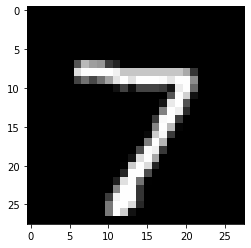

In [9]:
array = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32941176470588235, 0.7254901960784313, 0.6235294117647059, 0.592156862745098, 0.23529411764705882, 0.1411764705882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882352941177, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9450980392156862, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.6666666666666666, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2627450980392157, 0.4470588235294118, 0.2823529411764706, 0.4470588235294118, 0.6392156862745098, 0.8901960784313725, 0.996078431372549, 0.8823529411764706, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9803921568627451, 0.8980392156862745, 0.996078431372549, 0.996078431372549, 0.5490196078431373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.25882352941176473, 0.054901960784313725, 0.2627450980392157, 0.2627450980392157, 0.2627450980392157, 0.23137254901960785, 0.08235294117647059, 0.9254901960784314, 0.996078431372549, 0.41568627450980394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3254901960784314, 0.9921568627450981, 0.8196078431372549, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627450980392157, 0.9137254901960784, 1.0, 0.3254901960784314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823529411764, 0.996078431372549, 0.9333333333333333, 0.17254901960784313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137254901960785, 0.9764705882352941, 0.996078431372549, 0.24313725490196078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.7333333333333333, 0.0196078431372549, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882, 0.803921568627451, 0.9725490196078431, 0.22745098039215686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49411764705882355, 0.996078431372549, 0.7137254901960784, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411764705882354, 0.984313725490196, 0.9411764705882353, 0.2235294117647059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980392156863, 0.8666666666666667, 0.996078431372549, 0.6509803921568628, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352941, 0.796078431372549, 0.996078431372549, 0.8588235294117647, 0.13725490196078433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901960784313725, 0.996078431372549, 0.996078431372549, 0.30196078431372547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862745098039, 0.8784313725490196, 0.996078431372549, 0.45098039215686275, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23921568627450981, 0.9490196078431372, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.996078431372549, 0.8588235294117647, 0.1568627450980392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.8117647058823529, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
plt.imshow(array, cmap='gray')
plt.show()

Then, replace the `<MODEL_DEPLOYMENT_ENDPOINT>` in the below cell with `https://.../predictions` (Endpoint value copied from deployment detail page).

In [10]:
%env ENDPOINT=<MODEL_DEPLOYMENT_ENDPOINT>

env: ENDPOINT=https://hub.a.demo.primehub.io/deployment/pytorch-quickstart-xg1qv/api/v1.0/predictions


Run below cell to send request to deployed model endpoint.

In [11]:
response=!curl -X POST $ENDPOINT \
    -H 'Content-Type: application/json' \
    -d '{ "data": {"ndarray": [[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32941176470588235, 0.7254901960784313, 0.6235294117647059, 0.592156862745098, 0.23529411764705882, 0.1411764705882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882352941177, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9450980392156862, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.6666666666666666, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2627450980392157, 0.4470588235294118, 0.2823529411764706, 0.4470588235294118, 0.6392156862745098, 0.8901960784313725, 0.996078431372549, 0.8823529411764706, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9803921568627451, 0.8980392156862745, 0.996078431372549, 0.996078431372549, 0.5490196078431373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.25882352941176473, 0.054901960784313725, 0.2627450980392157, 0.2627450980392157, 0.2627450980392157, 0.23137254901960785, 0.08235294117647059, 0.9254901960784314, 0.996078431372549, 0.41568627450980394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3254901960784314, 0.9921568627450981, 0.8196078431372549, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627450980392157, 0.9137254901960784, 1.0, 0.3254901960784314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823529411764, 0.996078431372549, 0.9333333333333333, 0.17254901960784313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137254901960785, 0.9764705882352941, 0.996078431372549, 0.24313725490196078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.7333333333333333, 0.0196078431372549, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882, 0.803921568627451, 0.9725490196078431, 0.22745098039215686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49411764705882355, 0.996078431372549, 0.7137254901960784, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411764705882354, 0.984313725490196, 0.9411764705882353, 0.2235294117647059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980392156863, 0.8666666666666667, 0.996078431372549, 0.6509803921568628, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352941, 0.796078431372549, 0.996078431372549, 0.8588235294117647, 0.13725490196078433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901960784313725, 0.996078431372549, 0.996078431372549, 0.30196078431372547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862745098039, 0.8784313725490196, 0.996078431372549, 0.45098039215686275, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23921568627450981, 0.9490196078431372, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.996078431372549, 0.8588235294117647, 0.1568627450980392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.8117647058823529, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]] } }'

In the following cells, we will parse the model response to find the highest prediction probability.

In [12]:
result = json.loads(response[-1])

Print out response data.

In [13]:
result

{'data': {'names': [],
  'ndarray': [[0.00018315463967155665,
    4.904441084363498e-06,
    0.006834655534476042,
    0.008108451962471008,
    3.3638239074207377e-06,
    2.1743151592090726e-05,
    4.081423412571894e-07,
    0.9828698039054871,
    0.0015571439871564507,
    0.0004164064594078809]]},
 'meta': {'requestPath': {'model': 'infuseai/pytorch-prepackaged:v0.2.0'}}}

In [14]:
print(f"The model predicts the number is {np.argmax(result['data']['ndarray'][0])}")

The model predicts the number is 7


We have versioned our trained model and further deploy it as an endpoint service that can respond to requests anytime from everywhere!

## 5. (Advanced) Use PrimeHub <a target="_blank" href="https://github.com/InfuseAI/primehub-python-sdk">Python SDK</a> to deploy the trained model

In addition to deploy the trained model via PrimeHub UI, we can simply use PrimeHub `Python SDK` to perform the same operations.

Let's install PrimeHub Python SDK with pip.

In [15]:
!pip install primehub-python-sdk

After installed, the SDK needs a configuration file stored in the `~/.primehub/config.json`.

Hence, back to PrimeHub UI and select `API Token` from the upper-right menu.

<img src="../tensorflow2/img/tensorflow2/5-1-menu.png"/>

In the `API Token` page, click on the `Request API Token` button.

<img src="../tensorflow2/img/tensorflow2/5-2-request-api-token.png"/>

After the token is granted, we can click on the `Download Config` button to save the `config.json` file locally.

<img src="../tensorflow2/img/tensorflow2/5-3-download-config.png"/>

Next, uploading the downloaded `config.json` file and moving it to the `~/.primehub/config.json`.

Verify configration with PrimeHub Python SDK.

In [16]:
import random, string
from primehub import PrimeHub, PrimeHubConfig
ph = PrimeHub(PrimeHubConfig())

if ph.is_ready():
    print("PrimeHub Python SDK setup successfully")
else:
    print("PrimeHub Python SDK couldn't get the information, please ensure your configuration is stored in the ~/.primehub/config.json")

PrimeHub Python SDK setup successfully


We can refer to <a target="_blank" href="https://github.com/InfuseAI/primehub-python-sdk/blob/main/docs/notebook/deployments.ipynb">Deployments command</a> to find out more useful manipulations of PrimeHub Python SDK.

List all deployments.

In [17]:
ph.deployments.list()

[{'id': 'pytorch-quickstart-xg1qv',
  'name': 'pytorch-quickstart',
  'modelImage': 'infuseai/pytorch-prepackaged:v0.2.0',
  'imagePullSecret': None,
  'description': None,
  'replicas': 1,
  'stop': False,
  'endpointAccessType': 'public',
  'endpointClients': [],
  'status': 'Deployed',
  'endpoint': 'https://hub.a.demo.primehub.io/deployment/pytorch-quickstart-xg1qv/api/v1.0/predictions',
  'availableReplicas': 1,
  'message': 'Deployment is deployed and available now',
  'pods': [{'name': 'deploy-pytorch-quickstart-xg1qv-6c84f5ff77-b5ntw'}]}]

Delete the `pytorch-quickstart` deployment that we created early.

In [18]:
ph.deployments.delete(ph.deployments.list()[0]["id"])

{'id': 'pytorch-quickstart-xg1qv'}

Create a new deployment by specifing its config information:
- `id`: the prefix of pytorch-sdk-quickstart along with random string
- `name`: pytorch-sdk-quickstart
- `modelImage`: a pre-packaged model server image that can serve PyTorch model
- `modelURI`: the trained model logged in MLflow server
- `instanceType`: cpu-1 (CPU: 1 / Memory: 2G / GPU: 0)
- `replicas`: 1

In [19]:
config = {
    "id": f"pytorch-sdk-quickstart-{''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(5))}",
    "name": "pytorch-sdk-quickstart",
    "modelImage": "infuseai/pytorch-prepackaged:v0.2.0",
    "modelURI": "models:/pytorch-quickstart/1",
    "instanceType": "cpu-1",
    "replicas": 1
}

deployment = ph.deployments.create(config)
print(deployment)

{'id': 'pytorch-sdk-quickstart-vry96', 'name': 'pytorch-sdk-quickstart', 'modelImage': 'infuseai/pytorch-prepackaged:v0.2.0', 'imagePullSecret': None, 'description': None, 'replicas': 1, 'stop': False, 'endpointAccessType': 'public', 'endpointClients': [], 'status': 'Deploying', 'endpoint': None, 'availableReplicas': None, 'message': None, 'pods': []}


Keep waiting until deployed.

In [20]:
ph.deployments.wait(deployment["id"])

{'id': 'pytorch-sdk-quickstart-vry96',
 'name': 'pytorch-sdk-quickstart',
 'modelImage': 'infuseai/pytorch-prepackaged:v0.2.0',
 'imagePullSecret': None,
 'description': None,
 'replicas': 1,
 'stop': False,
 'endpointAccessType': 'public',
 'endpointClients': [],
 'status': 'Deployed',
 'endpoint': 'https://hub.a.demo.primehub.io/deployment/pytorch-sdk-quickstart-vry96/api/v1.0/predictions',
 'availableReplicas': 1,
 'message': 'Deployment is deployed and available now',
 'pods': [{'name': 'deploy-pytorch-sdk-quickstart-vry96-ddd4d7cdf-rbzz7'}]}

After deployed, parsing the deployment endpoint.

In [21]:
endpoint = ph.deployments.get(deployment["id"])["endpoint"]
%env ENDPOINT=$endpoint

env: ENDPOINT=https://hub.a.demo.primehub.io/deployment/pytorch-sdk-quickstart-vry96/api/v1.0/predictions


Run below cell to send request to deployed model endpoint.

In [22]:
response=!curl -X POST $ENDPOINT \
    -H 'Content-Type: application/json' \
    -d '{ "data": {"ndarray": [[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32941176470588235, 0.7254901960784313, 0.6235294117647059, 0.592156862745098, 0.23529411764705882, 0.1411764705882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882352941177, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9450980392156862, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.6666666666666666, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2627450980392157, 0.4470588235294118, 0.2823529411764706, 0.4470588235294118, 0.6392156862745098, 0.8901960784313725, 0.996078431372549, 0.8823529411764706, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9803921568627451, 0.8980392156862745, 0.996078431372549, 0.996078431372549, 0.5490196078431373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.25882352941176473, 0.054901960784313725, 0.2627450980392157, 0.2627450980392157, 0.2627450980392157, 0.23137254901960785, 0.08235294117647059, 0.9254901960784314, 0.996078431372549, 0.41568627450980394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3254901960784314, 0.9921568627450981, 0.8196078431372549, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627450980392157, 0.9137254901960784, 1.0, 0.3254901960784314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823529411764, 0.996078431372549, 0.9333333333333333, 0.17254901960784313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137254901960785, 0.9764705882352941, 0.996078431372549, 0.24313725490196078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.7333333333333333, 0.0196078431372549, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882, 0.803921568627451, 0.9725490196078431, 0.22745098039215686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49411764705882355, 0.996078431372549, 0.7137254901960784, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411764705882354, 0.984313725490196, 0.9411764705882353, 0.2235294117647059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980392156863, 0.8666666666666667, 0.996078431372549, 0.6509803921568628, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352941, 0.796078431372549, 0.996078431372549, 0.8588235294117647, 0.13725490196078433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901960784313725, 0.996078431372549, 0.996078431372549, 0.30196078431372547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862745098039, 0.8784313725490196, 0.996078431372549, 0.45098039215686275, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23921568627450981, 0.9490196078431372, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.996078431372549, 0.8588235294117647, 0.1568627450980392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.8117647058823529, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]] } }'

In the following cells, we will parse the model response to find the highest prediction probability.

In [23]:
result = json.loads(response[-1])

Print out response data.

In [24]:
result

{'data': {'names': [],
  'ndarray': [[0.00018315463967155665,
    4.904441084363498e-06,
    0.006834655534476042,
    0.008108451962471008,
    3.3638239074207377e-06,
    2.1743151592090726e-05,
    4.081423412571894e-07,
    0.9828698039054871,
    0.0015571439871564507,
    0.0004164064594078809]]},
 'meta': {'requestPath': {'model': 'infuseai/pytorch-prepackaged:v0.2.0'}}}

In [25]:
print(f"The model predicts the number is {np.argmax(result['data']['ndarray'][0])}")

The model predicts the number is 7


Congratulations! We have efficiently deployed our model via PrimeHub Python SDK!

In the last, we can delete our deployment to ensure no resources will be wasted after this quickstart tutorial!

In [26]:
ph.deployments.delete(deployment["id"])

{'id': 'pytorch-sdk-quickstart-vry96'}